In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import random
from classes.heston_hull_white import HestonHullWhite

SEED = 117
random.seed(SEED)
np.random.seed(SEED)

[*********************100%***********************]  1 of 1 completed


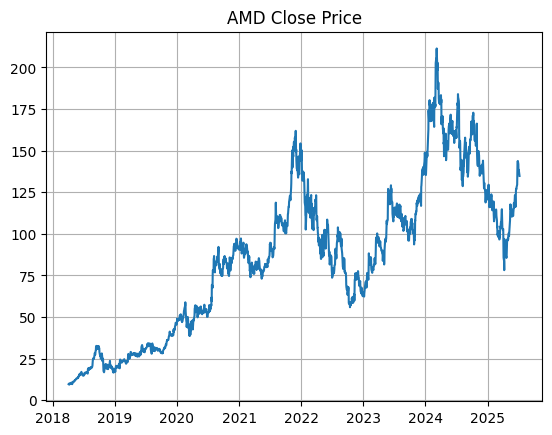

In [2]:
ticker_symbol = 'AMD'
ticker = yf.Ticker(ticker_symbol)

start_date = '2018-04-03'
ref_date = pd.to_datetime('2025-07-07')
ticker_data = yf.download(ticker_symbol, start=start_date, end=ref_date + pd.to_timedelta(1, 'D'), auto_adjust=True)

price_df = pd.DataFrame({f'{ticker_symbol} Close': ticker_data['Close'][ticker_symbol]}, index=pd.to_datetime(ticker_data.index))
price_df[f'{ticker_symbol} Log Returns'] = np.log(price_df[f'{ticker_symbol} Close'] / price_df[f'{ticker_symbol} Close'].shift(1))
price_df.dropna(inplace=True)

plt.plot(price_df.index, price_df[f'{ticker_symbol} Close'])
plt.title(f'{ticker_symbol} Close Price')
plt.grid(True)
plt.show()

Estimated correlation between SOFR first differences and stock log-returns: -0.0676


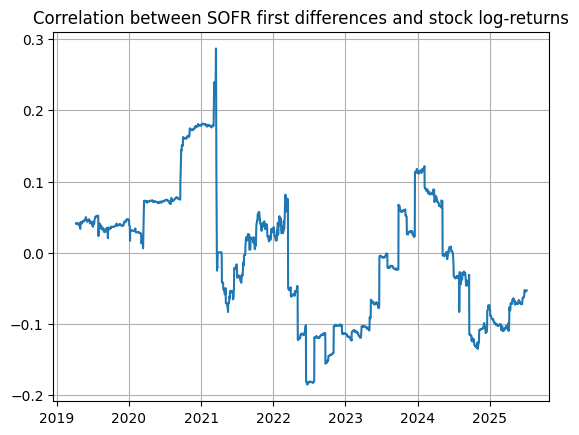

In [3]:
# Load SOFR dataset
sofr_file_path = './data/sofr.csv'
sofr_df = pd.read_csv(sofr_file_path)
sofr_df['Date'] = pd.to_datetime(sofr_df['Date'])
sofr_df = sofr_df.dropna()
sofr_df = sofr_df.sort_values('Date')
sofr_df['SOFR'] = sofr_df['SOFR'].astype(float) * 0.01
sofr_df = sofr_df[sofr_df['Date'] <= ref_date]
sofr_df.set_index('Date', inplace=True)

# Join datasets by index
price_rate_df = sofr_df.join(price_df, how='inner')
# Calculate first differences of SOFR timeseries
price_rate_df['SOFR diff'] = price_rate_df['SOFR'].diff()
price_rate_df.dropna(inplace=True)

# Calculate rolling correlation between stock log returns and SOFR first differences
corr_window = 252
sofr_stock_rolling_corr = price_rate_df[f'{ticker_symbol} Log Returns'].rolling(window=corr_window).corr(price_rate_df['SOFR diff'])
sofr_stock_rolling_corr.dropna(inplace=True)
# Calculate EWMA of rolling correlation
sofr_stock_rolling_corr_ewma = sofr_stock_rolling_corr.ewm(span=252).mean()
sofr_stock_corr = sofr_stock_rolling_corr_ewma.values[-1]

print(f'Estimated correlation between SOFR first differences and stock log-returns: {sofr_stock_corr:.4f}')
plt.plot(price_rate_df.index[corr_window-1:], sofr_stock_rolling_corr)
plt.title('Correlation between SOFR first differences and stock log-returns')
plt.grid(True)
plt.show()

In [4]:
# Calibrate Vasicek model
rates = sofr_df['SOFR'].values

hhw_model = HestonHullWhite()
hhw_model.calibrate_vasicek(rates=rates, dt=1/252.)

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: -9737.503689484081
        x: [ 3.413e-01  3.507e-02  1.782e-02]
      nit: 33
      jac: [ 0.000e+00  1.819e-04  2.947e-02]
     nfev: 232
     njev: 58
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [5]:
# Load options calibration dataset
call_opt_calib_file_path = f'./data/{ticker_symbol}_{ref_date.date()}_options.csv'
call_opt_calib_df = pd.read_csv(call_opt_calib_file_path)
call_opt_calib_df['maturity'] = pd.to_datetime(call_opt_calib_df['maturity'])
call_opt_calib_df['timeToMaturity'] = (call_opt_calib_df['maturity'] - ref_date) / (360 * pd.to_timedelta(1, 'D'))
call_opt_data = call_opt_calib_df[['lastPrice', 'timeToMaturity', 'strike', 'optType']].to_numpy()

# Calibrate Heston model
r0 = sofr_df.loc[ref_date]['SOFR']
S0 = price_df.loc[ref_date][f'{ticker_symbol} Close']
hhw_model.set_params({'r0': r0, 'rho_xr': sofr_stock_corr, 'q': 0})

hhw_model.calibrate_heston(S0=S0, calib_opt_data=call_opt_data, call_opt_id='call')

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.6720209800663252
       x: [ 3.518e-01  2.188e-01 -9.000e-01  5.000e+00  9.000e-01]
     nit: 20
     jac: [-1.660e-02 -1.984e-02  1.501e-03 -1.224e-02 -4.846e-02]
    nfev: 126
    njev: 20

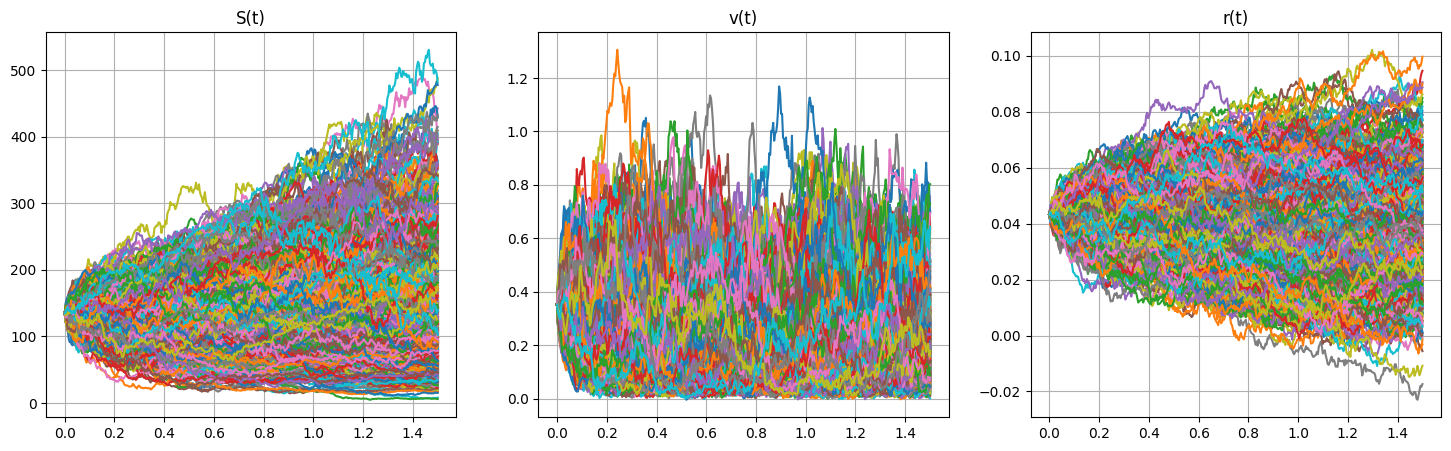

In [6]:
mc_paths = 10000
mc_time_step = 1 / 252.
mc_T = 1.5

S_paths, v_paths, r_paths = hhw_model.simulate_paths(n_paths=mc_paths, dt=mc_time_step, T=mc_T, S0=S0)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
t_array = np.linspace(0, mc_T, S_paths.shape[1])
axes[0].plot(t_array, S_paths[:1000,].T)
axes[0].set_title('S(t)')
axes[0].grid(True)

axes[1].plot(t_array, v_paths[:1000,].T)
axes[1].set_title('v(t)')
axes[1].grid(True)

axes[2].plot(t_array, r_paths[:1000,].T)
axes[2].set_title('r(t)')
axes[2].grid(True)

plt.show()